In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
data = pd.read_csv('developers.csv')

In [4]:
data['year_quarter'] = data['year'].astype(str) + '-Q' + data['quarter'].astype(str)

In [5]:
pivot_data = data.pivot_table(index='iso2_code', columns='year_quarter', values='developers', aggfunc='sum')

In [6]:
top_countries = pivot_data.sum(axis=1).nlargest(4).index
top_countries

Index(['US', 'CN', 'IN', 'BR'], dtype='object', name='iso2_code')

In [7]:
colors_and_markers = {
    'US': {'color': 'blue', 'marker': '^'},  
    'CN': {'color': 'orange', 'marker': 'x'},  
    'IN': {'color': 'green', 'marker': 'o'},  
    'BR': {'color': 'red', 'marker': 's'}, 
}

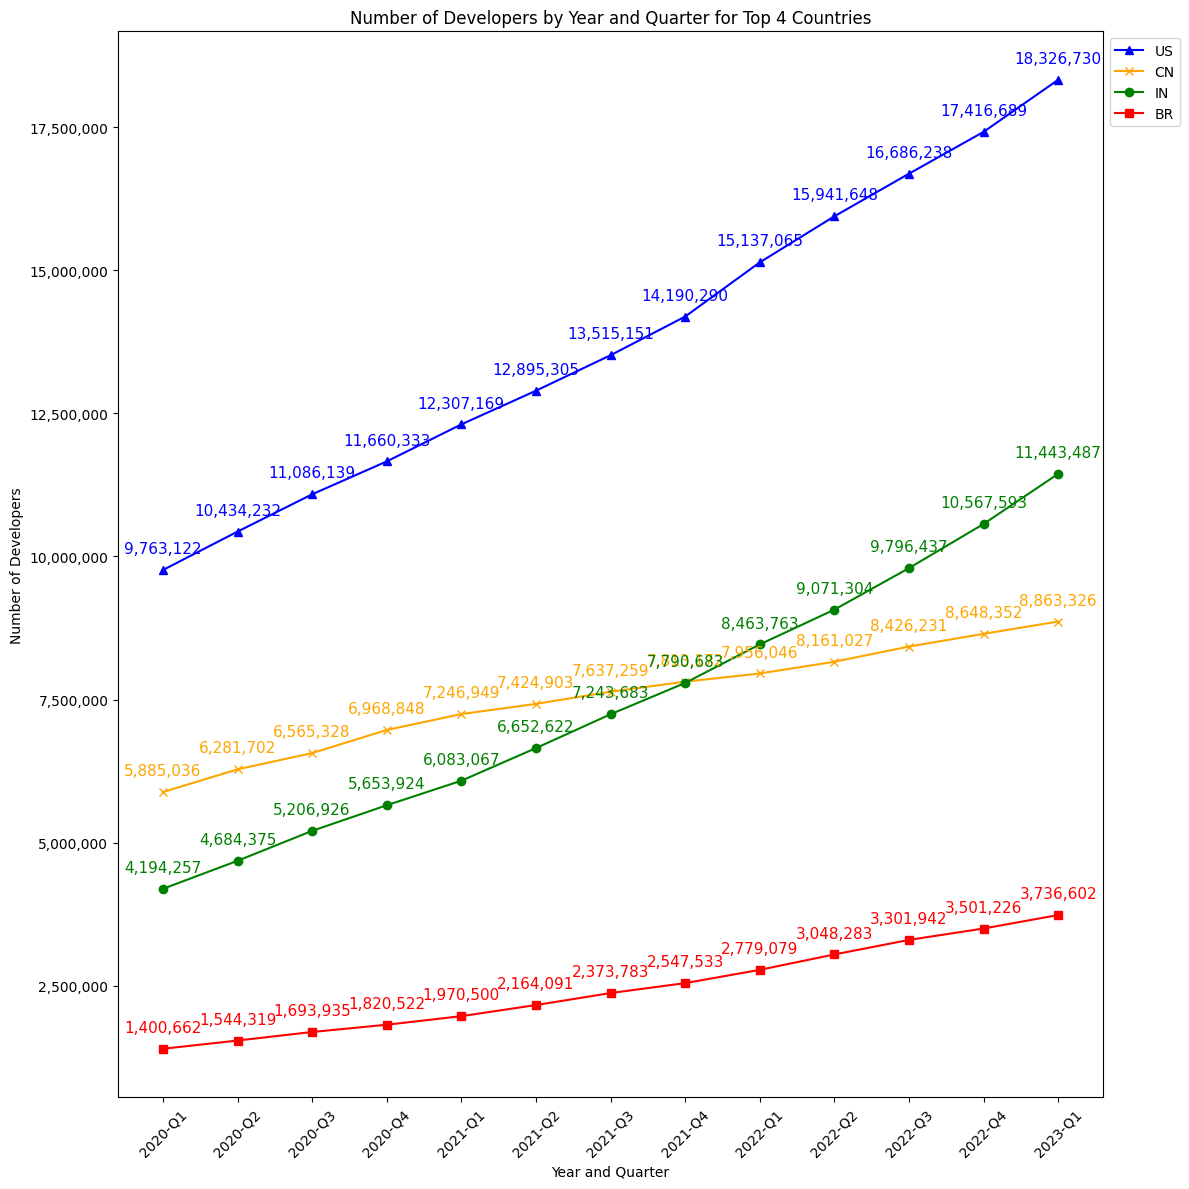

In [8]:
plt.figure(figsize=(12, 12))

for country in top_countries:
    plt.plot(pivot_data.columns, pivot_data.loc[country], 
             marker=colors_and_markers[country]['marker'], 
             color=colors_and_markers[country]['color'], 
             label=country)
    
    for x, y in zip(pivot_data.columns, pivot_data.loc[country]):
        plt.annotate(f'{y:,.0f}', 
                     xy=(x, y), 
                     xycoords='data', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     ha='center', 
                     va='bottom',
                     color=colors_and_markers[country]['color'],
                     fontsize=11)


plt.xticks(rotation=45)
plt.xlabel('Year and Quarter')
plt.ylabel('Number of Developers')
plt.title('Number of Developers by Year and Quarter for Top 4 Countries')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)


ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()


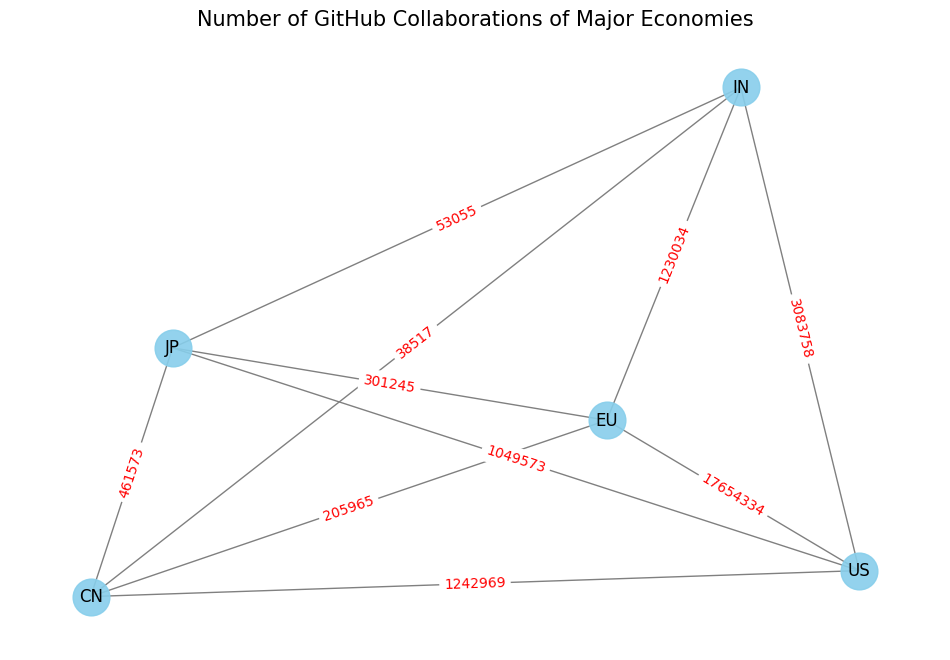

In [9]:
import networkx as nx

data2 = pd.read_csv('economy_collaborators.csv')
major_economies = ['US', 'CN', 'EU', 'IN', 'JP']

filtered_data = data2[(data2['source'].isin(major_economies)) & (data2['destination'].isin(major_economies))].copy()
filtered_data['country_pair'] = filtered_data.apply(lambda x: '-'.join(sorted([x['source'], x['destination']])), axis=1)
data_summed = filtered_data.groupby('country_pair').agg({'weight': 'sum'}).reset_index()

G = nx.Graph()

for index, row in data_summed.iterrows():
    countries = row['country_pair'].split('-')
    G.add_edge(countries[0], countries[1], weight=row['weight'])

plt.figure(figsize=(12, 8))

#layout
pos = nx.spring_layout(G, k=0.5, seed=3)  # 所有节点的位置
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
nx.draw_networkx_edges(G, pos, edge_color="grey")

#labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Number of GitHub Collaborations of Major Economies", size=15)
plt.axis('off')
plt.show()


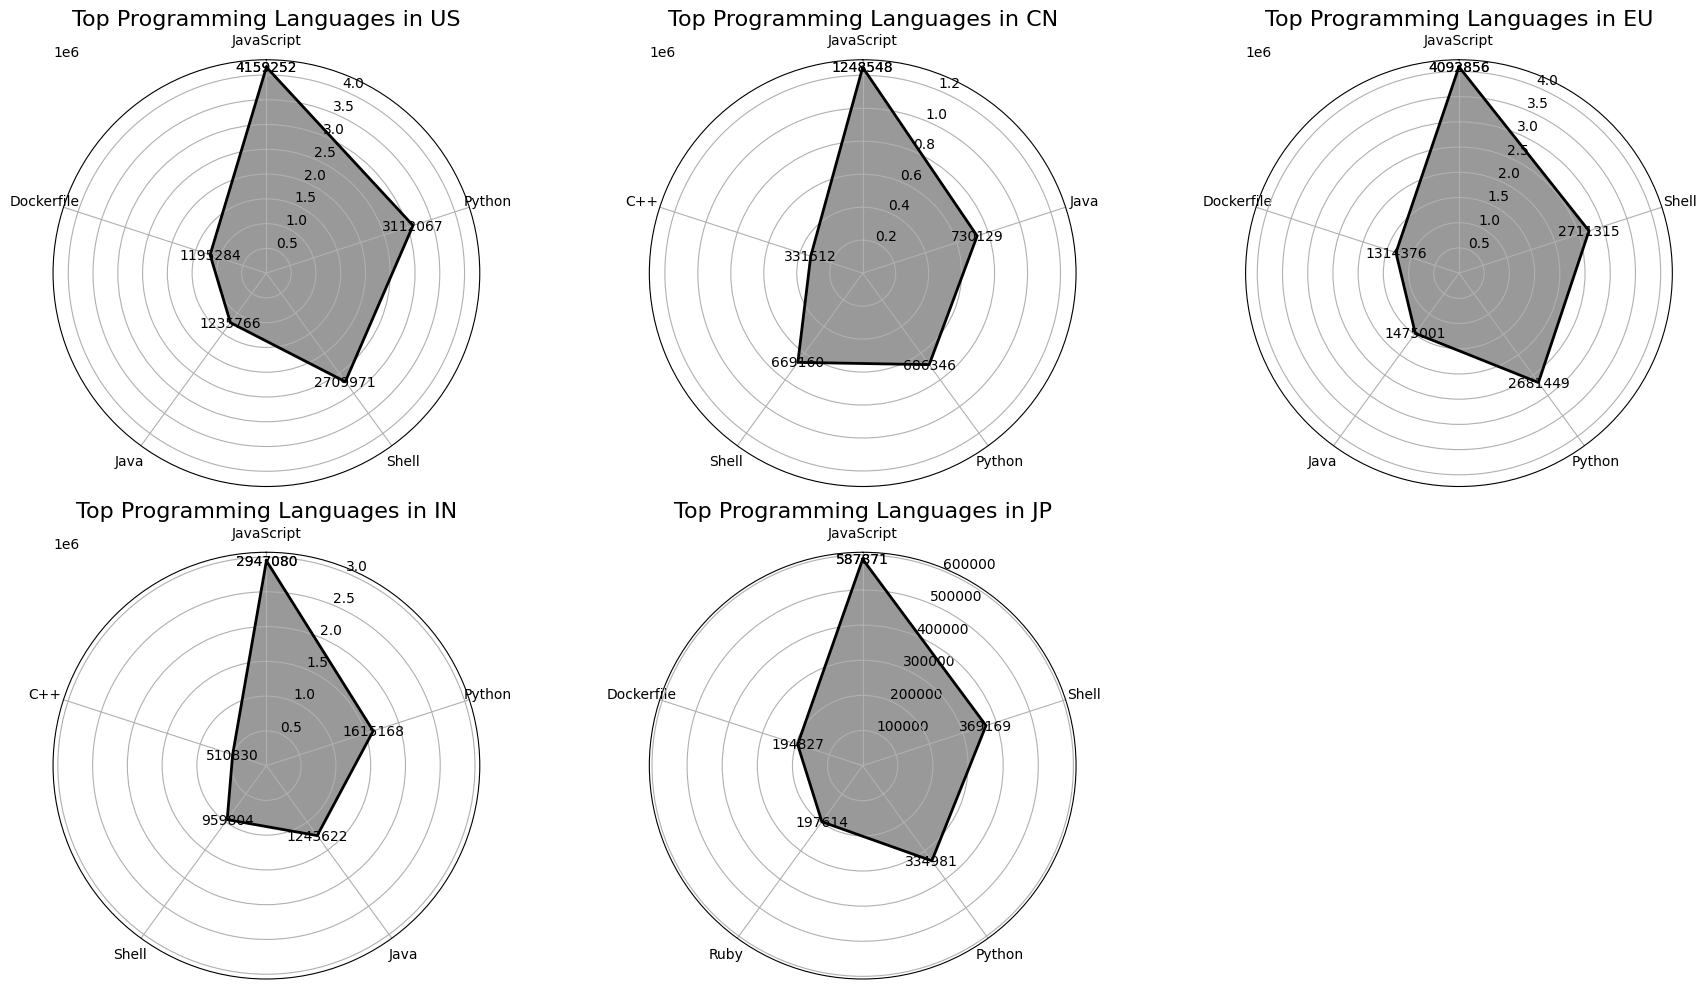

In [11]:
import numpy as np
from math import pi

data3 = pd.read_csv('languages.csv')
# Function to create a radar chart for the top languages in a given economy
def create_radar_chart(ax, economy_data, title):
    # Number of variables we're plotting.
    num_vars = len(economy_data)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first value to close the circle

    # The plot is made circular, so we need to "complete the loop"
    values = economy_data['num_pushers'].tolist()
    values += values[:1]

    # Draw the outline of our data.
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(economy_data['language'])

    
    # Plot data and fill with color
    ax.plot(angles, values, color='black', linewidth=2, linestyle='solid')
    ax.fill(angles, values, color='black', alpha=0.4)

    # Add data labels at each point
    for angle, value in zip(angles, values):
        ax.text(angle, value, str(value), color='black', ha='center', va='center')
        

    # Add a title with the economy name
    ax.set_title(title, size=16, color='black', position=(0.5, 1.1))

# Generate the radar charts for each economy
# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw=dict(polar=True))

# Flatten the axes array for easy use
axes = axes.flatten()

# Iterate over economies and create a radar chart for each
for i, economy in enumerate(major_economies):
    # Filter the data for the current economy
    economy_data = data3[(data3['iso2_code'] == economy) & (data3['language_type'] == 'programming')]
    # Select the top 5 languages for the current economy
    top_languages = economy_data.groupby('language')['num_pushers'].sum().nlargest(5).reset_index()
    # Create the radar chart
    create_radar_chart(axes[i], top_languages, 'Top Programming Languages in ' + economy)

# Hide the unused subplot (if number of economies is not multiple of 3)
if len(axes) > len(major_economies):
    for i in range(len(major_economies), len(axes)):
        fig.delaxes(axes[i])

# Tight layout often produces nicer looking plots
plt.tight_layout()

# Show the plot
plt.show()